In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadmoosavi","key":"1fa1bc8aae4bfd517b860f44615ff8d9"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d unclesamulus/blood-cells-image-dataset

100% 267M/268M [00:01<00:00, 135MB/s]
100% 268M/268M [00:01<00:00, 145MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "blood-cells-image-dataset.zip"

with ZipFile(file_name,'r') as zipp:
  zipp.extractall()
print('done') 

done


In [ ]:
pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
input_folder = "/content/bloodcells_dataset"
output = "/content/splited_dataset"

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.7, .1, .2)) 

Copying files: 17092 files [00:02, 6077.05 files/s]


In [ ]:
import matplotlib.pyplot as plt 
import numpy as np             
import pandas as pd           

train_path = '/content/splited_dataset/train'
test_path = '/content/splited_dataset/test'
valid_path = '/content/splited_dataset/val'

#set defult image size
batch_size = 16
img_width = 224
img_height = 224

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                rotation_range=15,
                                width_shift_range=0.05,
                                height_shift_range=0.05,
                                rescale = 1./255,
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True,
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='rgb',
      class_mode='sparse',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='rgb',
      shuffle=False, 
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode='sparse',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='rgb',
      class_mode='sparse', 
      batch_size=batch_size
      )

Found 11959 images belonging to 8 classes.
Found 3428 images belonging to 8 classes.
Found 1705 images belonging to 8 classes.


In [ ]:
from tensorflow.keras.applications import ResNet101V2

conv_base = ResNet101V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

conv_base.summary()

171317808/171317808 [==============================] - 1s 0us/step
Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                     

In [ ]:
from keras import models
from keras import layers
from tensorflow import keras
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop

optimizer = keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)

model = models.Sequential()

model.add(Conv2D(3, (3, 3), padding="same", activation="relu", input_shape=(img_width, img_height, 1)))

model.add(conv_base)

model.add(GlobalAveragePooling2D())

model.add(layers.Flatten())
#model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
#model.add(layers.BatchNormalization())

#model.add(layers.Dense(4096, activation='relu'))
#model.add(Dense(activation = 'relu', units = 64))
model.add(Dense(8,activation="softmax"))
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
#model.compile(optimizer = RMSprop(lr=1e-2) , loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

conv_base.trainable = False
#fine-tuning
'''
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
'''
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                        

In [ ]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

#early stopping
early = EarlyStopping(monitor="val_loss", 
                      mode="auto", 
                      patience=9)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 4, verbose=1,factor=1e-1, min_lr=0.000001)

checkpoint_filepath = 'checkpointCNN1.h5'
Model_check = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

checkpoint_filepath1 = 'checkpointCNN2.h5'
Model_check1 = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath1, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')

callbacks_list = [ early, learning_rate_reduction]

In [14]:
history = model.fit(train,
                    batch_size=16,
                    epochs=10,
                    validation_data=valid,
                    callbacks=[early,learning_rate_reduction, Model_check, Model_check1])

Epoch 1/10
748/748 [==============================] - ETA: 0s - loss: 0.5506 - accuracy: 0.8151
Epoch 1: val_loss improved from inf to 0.50693, saving model to checkpointCNN1.h5

Epoch 1: saving model to checkpointCNN2.h5
748/748 [==============================] - 266s 328ms/step - loss: 0.5506 - accuracy: 0.8151 - val_loss: 0.5069 - val_accuracy: 0.8182 - lr: 0.0030
Epoch 2/10
748/748 [==============================] - ETA: 0s - loss: 0.2351 - accuracy: 0.9245
Epoch 2: val_loss improved from 0.50693 to 0.27390, saving model to checkpointCNN1.h5

Epoch 2: saving model to checkpointCNN2.h5
748/748 [==============================] - 245s 327ms/step - loss: 0.2351 - accuracy: 0.9245 - val_loss: 0.2739 - val_accuracy: 0.9109 - lr: 0.0030
Epoch 3/10
748/748 [==============================] - ETA: 0s - loss: 0.1636 - accuracy: 0.9461
Epoch 3: val_loss improved from 0.27390 to 0.20524, saving model to checkpointCNN1.h5

Epoch 3: saving model to checkpointCNN2.h5
748/748 [=====================

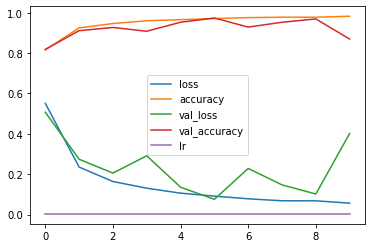

In [15]:
pd.DataFrame(model.history.history).plot()

In [16]:
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')
preds = model.predict(test,verbose=1)

215/215 [==============================] - 20s 91ms/step - loss: 0.4226 - accuracy: 0.8635
The testing accuracy is : 86.34772300720215 %
215/215 [==============================] - 20s 84ms/step


In [17]:
from keras.models import load_model  
model = load_model('checkpointCNN1.h5')
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')
preds2 = model.predict(test,verbose=1)

215/215 [==============================] - 21s 89ms/step - loss: 0.0882 - accuracy: 0.9740
The testing accuracy is : 97.40373492240906 %
215/215 [==============================] - 20s 84ms/step


In [18]:
import numpy as np
rounded_labels=np.argmax(preds, axis=1)
rounded_labels[1]

rounded_labels2=np.argmax(preds2, axis=1)
rounded_labels2[1]

0

In [ ]:
from sklearn.metrics import confusion_matrix
cmm = confusion_matrix(rounded_labels, test.classes)
cmm

cnn = confusion_matrix(rounded_labels2, test.classes)
cnn

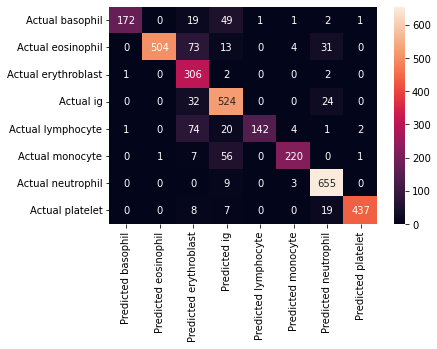

In [19]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, rounded_labels, labels=[0, 1, 2, 3, 4, 5, 6, 7]),index=["Actual basophil", "Actual eosinophil", "Actual erythroblast", "Actual ig", "Actual lymphocyte", "Actual monocyte", "Actual neutrophil", "Actual platelet"],
columns=["Predicted basophil", "Predicted eosinophil", "Predicted erythroblast", "Predicted ig", "Predicted lymphocyte", "Predicted monocyte", "Predicted neutrophil", "Predicted platelet"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

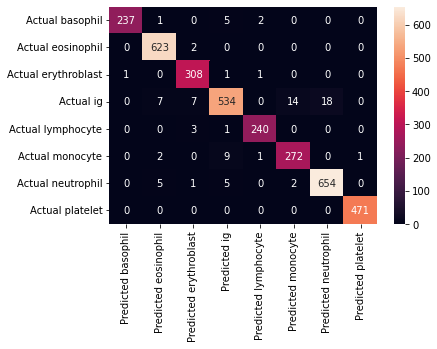

In [20]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, rounded_labels2, labels=[0, 1, 2, 3, 4, 5, 6, 7]),index=["Actual basophil", "Actual eosinophil", "Actual erythroblast", "Actual ig", "Actual lymphocyte", "Actual monocyte", "Actual neutrophil", "Actual platelet"],
columns=["Predicted basophil", "Predicted eosinophil", "Predicted erythroblast", "Predicted ig", "Predicted lymphocyte", "Predicted monocyte", "Predicted neutrophil", "Predicted platelet"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [21]:
print(classification_report(y_true=test.classes,y_pred=rounded_labels,target_names =["basophil", "eosinophil", "erythroblast", "ig", "lymphocyte", "monocyte", "neutrophil", "platelet"]))

print(classification_report(y_true=test.classes,y_pred=rounded_labels2,target_names =["basophil", "eosinophil", "erythroblast", "ig", "lymphocyte", "monocyte", "neutrophil", "platelet"]))

              precision    recall  f1-score   support

    basophil       0.99      0.70      0.82       245
  eosinophil       1.00      0.81      0.89       625
erythroblast       0.59      0.98      0.74       311
          ig       0.77      0.90      0.83       580
  lymphocyte       0.99      0.58      0.73       244
    monocyte       0.95      0.77      0.85       285
  neutrophil       0.89      0.98      0.94       667
    platelet       0.99      0.93      0.96       471

    accuracy                           0.86      3428
   macro avg       0.90      0.83      0.85      3428
weighted avg       0.90      0.86      0.87      3428

              precision    recall  f1-score   support

    basophil       1.00      0.97      0.98       245
  eosinophil       0.98      1.00      0.99       625
erythroblast       0.96      0.99      0.97       311
          ig       0.96      0.92      0.94       580
  lymphocyte       0.98      0.98      0.98       244
    monocyte       0.94 